In [1]:
from skimage.io import imread
import numpy as np
from matplotlib import pyplot as plt
import time

In [2]:
rootfolder = '..'

Useful function for plot the 2D DCT dictionary

In [3]:
def get_dictionary_img(D):
    M, N = D.shape
    p = int(round(np.sqrt(M)))
    nnn = int(np.ceil(np.sqrt(N)))
    bound = 2
    img = np.ones((nnn*p+bound*(nnn-1), nnn*p+bound*(nnn-1)))
    for i in range(N):
        m = np.mod(i, nnn)
        n = int((i-m)/nnn)
        m = m * p + bound * m
        n = n * p + bound * n
        atom = D[:, i].reshape((p, p))
        if atom.min() < atom.max():
            atom = (atom - atom.min()) / (atom.max() - atom.min())
        img[m: m + p, n: n + p] = atom

    return img

Define a function that implements the OMP

In [4]:
def OMP(s, D, L, tau):
    M, N = D.shape
    x = np.zeros(N)
    
    # residual
    r =  s - (D @ x)
    
    # support set
    omega = []
    
    while np.linalg.norm(r) > tau and np.count_nonzero(x) < L:

        # SWEEP STEP: look for the column of D that matches at best noisySignal
        # compute the residual w.r.t. each column of D
        e = np.zeros(N)
        for j in range(N):
            dj = D[:,j]
            zj = ((r.T @ dj) / np.linalg.norm(dj))**2
            e[j] = np.linalg.norm(r)**2 - zj

        # find the column of D that matches at best r
        jStar = np.argmin(e)

        # UPDATE the support set with the jStar coefficient
        omega.append(jStar)
        # this makes sense but it makes the graph soften the spikes because it's not using all the points
        # if jStar not in omega: # because omega is a set
        #     omega.append(jStar) # this also guarantees to obtain a singular matrix

        # update the coefficients by solving the least square problem min ||D_omega x - s ||
        D_omega = D[:,omega]
        l_term = np.linalg.inv(D_omega.T @ D_omega)
        r_term = D_omega.T @ s
        x_omega = l_term @ r_term

        x[omega] = x_omega

        # update the residual
        r = s - (D @ x)

    return x

Load the image and rescale it in $[0,1]$

In [5]:
# img = imread(f'{rootfolder}/data/cameraman.png') / 255
img = imread(f'{rootfolder}/data/barbara.png') / 255
# img = imread(f'{rootfolder}/data/Lena512.png') / 255

imsz = img.shape

# patch size
p = 8

# number of elements in the patch
M = p ** 2


Extract a bunch of random patches from the image

In [6]:
npatch = 10000

S = np.zeros((M, npatch))

for i in range(npatch):
    top_left_y = np.random.randint(0, imsz[0] - p + 1)
    top_left_x = np.random.randint(0, imsz[1] - p + 1)
    patch = img[top_left_y:top_left_y+p, top_left_x:top_left_x+p]
    patch_unrolled = patch.reshape(-1)
    
    # Assign the unrolled patch to the column i of S
    S[:, i] = patch_unrolled

Remove the mean from the patches (each column of $S$ must have zero-mean)

In [7]:
# S = S - np.mean(S) # not the same
S = S - S.mean(axis=0)
S

array([[ 0.06819853,  0.05165441,  0.12126225, ..., -0.25968137,
        -0.00857843, -0.04571078],
       [-0.00238971,  0.05165441,  0.24283088, ...,  0.19129902,
        -0.16151961,  0.07585784],
       [-0.01415441,  0.03988971, -0.05520833, ...,  0.07365196,
         0.04632353,  0.02487745],
       ...,
       [ 0.04466912, -0.0463848 , -0.00422794, ...,  0.15992647,
         0.08161765,  0.22095588],
       [-0.02591912, -0.05030637, -0.00814951, ..., -0.21262255,
         0.10514706, -0.2064951 ],
       [-0.29650735, -0.05814951, -0.00814951, ..., -0.02046569,
        -0.09877451, -0.00257353]])

Initialize the dictionary and the coefficient matrix

In [8]:
# number of columns of the dictionary
N = 256

# intialize the dictionary
D = np.random.randn(M, N) # randn does a normal distribution :)

# normalize each column of D (zero mean and unit norm)
# UPDATE D
D = D - D.mean(axis=0)
D = D / np.linalg.norm(D)

# number of iteration of the KSVD
max_iter = 10
# max_iter = 3

# maximum number of nonzero coefficients for the sparse coding
L = 4

# initialize the coefficient matrix
X = np.zeros((N, npatch))

# tau
tau = 0

In [9]:
print(X.shape)
print(D.shape)

(256, 10000)
(64, 256)


Main KSVD loop


In [10]:
for iter in range(max_iter):
    time_start = time.time()
    print(f'iter {iter}')
    # perform the sparse coding via OMP of all the columns of S
    for n in range(npatch):
        X[:, n] = OMP(S[:,n],D,L,tau)
    
    # iterate over the columns of D
    for j in range(N):
        # find which signals uses the j-th atom in the sparse coding
        omega = np.where(X[j, :] != 0)[0]

        if len(omega) == 0:
            # if the atom is never used then ignore or substitute it with a random vector
            continue
        else:
            # compute the residual matrix E, ignoring the j-th atom
            D_less_j = np.delete(D, j, axis=1) # D without j column D-D[:,j]
            X_less_j = np.delete(X, j, axis=0) # D without j row X-X[j,:]
            
            E = S - (D_less_j @ X_less_j)

            # restrict E to the columns indicated by omega
            Eomega = E[:,omega]

            # compute the SVD of Eomega
            U, Sigma, V = np.linalg.svd(Eomega, full_matrices=False) # devolverá las matrices U y V con dimensiones reducidas.

            # update the dictionary
            D[:,j] = U[:,0].reshape(-1)

            # update the coefficient D
            g_hat = Sigma @ V # Sigma=(64,) V=(64,omega=103) result = (103,)
            X[j,omega] = g_hat.T # X[j,omega.shape] = (omega=103,)
    
    time_end = time.time()
    print(f'{time_end - time_start:.0f}')


iter 0
175
iter 1
169
iter 2
175
iter 3
176
iter 4
177
iter 5
168
iter 6
238
iter 7
243
iter 8
214
iter 9
188


Show the learned dictionary

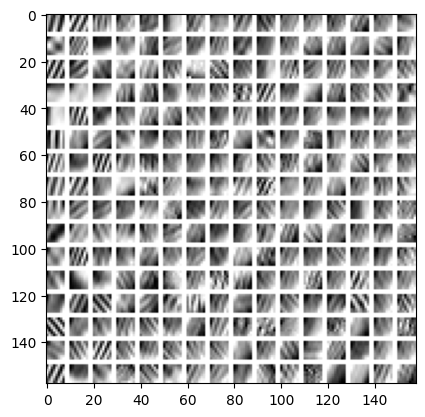

In [11]:
img_dict = get_dictionary_img(D)
plt.figure()
plt.imshow(img_dict, cmap='gray')
